In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import random
from scipy.stats import hypergeom
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("Sentence Quest WORDS.xlsx")
word_dict = {}
for col in df.columns:
    for word in df[col]:
        word_dict[word] = col
        
word_dict = {key: value for key, value in word_dict.items() if isinstance(key, str)}

In [3]:
set(word_dict.values())

{'ADJECTIVE',
 'ADVERB',
 'LINKING WORDS',
 'OBJECT-NOUN',
 'PREPOSITON',
 'SUBJECT - NOUN',
 'TIME ADVERB',
 'action VERBS',
 'modal VERBS',
 'negation',
 'sative VERBS'}

In [4]:
# Extract values (types) and count occurrences using Counter
type_counts = Counter(word_dict.values())

# Calculate total number of words
total_words = len(word_dict)

# Calculate distribution percentages
distribution = {word_type: count / total_words * 100 for word_type, count in type_counts.items()}

print("Word Type Distribution:")
for word_type, percentage in distribution.items():
    print(f"{word_type}: {percentage:.2f}%")

Word Type Distribution:
SUBJECT - NOUN: 14.97%
action VERBS: 17.01%
sative VERBS: 1.36%
modal VERBS: 2.04%
negation: 0.68%
OBJECT-NOUN: 24.49%
PREPOSITON: 7.48%
TIME ADVERB: 5.44%
ADVERB: 6.12%
ADJECTIVE: 16.33%
LINKING WORDS: 4.08%


In [54]:
og_dist = {
    'SUBJECT - NOUN': 22,
    'LINKING WORDS': 6,
    'action VERBS': 25,
    'sative VERBS': 2,
    'modal VERBS': 3,
    'negation': 1,
    'OBJECT-NOUN': 36,
    'PREPOSITON': 11,
    'TIME ADVERB': 8,
    'ADVERB': 9,
    'ADJECTIVE': 24
}
augmentation = {
    'SUBJECT - NOUN': 26,
    'LINKING WORDS': 4,
    'action VERBS': 27,
    'sative VERBS': 8,
    'modal VERBS': 5,
    'negation': 3,
    'OBJECT-NOUN': 30,
    'PREPOSITON': 9,
    'TIME ADVERB': 8,
    'ADVERB': 10,
    'ADJECTIVE': 18
}
DEFAULT_DISTRIBUTION = augmentation
DEFAULT_WORD_COUNT = sum(list(DEFAULT_DISTRIBUTION.values()))
INITIAL_CARDS = 8

In [55]:
DEFAULT_WORD_COUNT

147

## Statistical analysis

### Subject quantity problem

In [56]:
#Probability, that a player will not draw a single subject card in the opening round
share_not_subjects = (DEFAULT_WORD_COUNT-DEFAULT_DISTRIBUTION['SUBJECT - NOUN'])/DEFAULT_WORD_COUNT
(share_not_subjects)**INITIAL_CARDS

0.22508158638140946

In [57]:
##And after the first
print((share_not_subjects)**(INITIAL_CARDS+1))

0.18680240502402692


In [58]:
#and second round
print((share_not_subjects)**(INITIAL_CARDS+2))

0.15503328852334208


If we allow objects to act, rather than only to be acted upon, we get better numbers.

In [59]:
share_not_nouns = (DEFAULT_WORD_COUNT-DEFAULT_DISTRIBUTION['SUBJECT - NOUN']-DEFAULT_DISTRIBUTION['OBJECT-NOUN'])/DEFAULT_WORD_COUNT

In [60]:
#Probability that a player will not draw a single noun card in the opening round
(share_not_nouns)**INITIAL_CARDS

0.023537695530621218

So if we do not allow objects to act, we need to increase the number of subjects, probably at the cost of objects

In [61]:
probabilities = {'Word Type': [], 'Round 0': [], 'Round 1': [], 'Round 2': [], 'Round 3': [], 'Round 4': [], 'Round 5': [], '2P Round 0': [] ,'3P Round 0': [], '4P Round 0': [], 'EV first draw': [], '3P Round 2': [], '4P Round 2': []}

for word_type, quantity in DEFAULT_DISTRIBUTION.items():
    probability_not_drawn = 1 - (quantity / DEFAULT_WORD_COUNT)
    probabilities['Word Type'].append(word_type)
    for round_num in range(6):
        probabilities[f'Round {round_num}'].append(probability_not_drawn ** (INITIAL_CARDS + round_num))
        
    for players in range(2, 5):
        probabilities[f'{players}P Round 0'].append(probability_not_drawn ** (INITIAL_CARDS * (players)))
        
    for players in range(3, 5):
        probabilities[f'{players}P Round 2'].append(probability_not_drawn ** (INITIAL_CARDS * (players) + (players*2)))
        
    probabilities['EV first draw'].append(round(1/(quantity/DEFAULT_WORD_COUNT)))

In [62]:
stats_df = pd.DataFrame(probabilities)

In [63]:
stats_df

,Word Type,Round 0,Round 1,Round 2,Round 3,Round 4,Round 5,2P Round 0,3P Round 0,4P Round 0,EV first draw,3P Round 2,4P Round 2
0,SUBJECT - NOUN,0.225082,0.186802,0.155033,0.128667,0.106785,0.088624,0.050662,0.011403,0.002567,6,0.003726,0.000578
1,LINKING WORDS,0.801954,0.780132,0.758904,0.738254,0.718165,0.698623,0.643131,0.515761,0.413617,37,0.437080,0.331702
2,action VERBS,0.197202,0.160981,0.131413,0.107276,0.087572,0.071488,0.038889,0.007669,0.001512,5,0.002269,0.000298
3,sative VERBS,0.639116,0.604334,0.571445,0.540346,0.510940,0.483133,0.408469,0.261059,0.166847,18,0.186605,0.106635
4,modal VERBS,0.758173,0.732384,0.707473,0.683410,0.660164,0.637710,0.574826,0.435817,0.330425,29,0.354104,0.250519
5,negation,0.847932,0.830628,0.813676,0.797070,0.780804,0.764869,0.718989,0.609654,0.516946,49,0.538710,0.438335
6,OBJECT-NOUN,0.161045,0.128179,0.102020,0.081200,0.064628,0.051439,0.025936,0.004177,0.000673,5,0.001062,0.000108
7,PREPOSITON,0.603245,0.566312,0.531640,0.499090,0.468534,0.439848,0.363905,0.219524,0.132427,16,0.150263,0.079886
8,TIME ADVERB,0.639116,0.604334,0.571445,0.540346,0.510940,0.483133,0.408469,0.261059,0.166847,18,0.186605,0.106635
9,ADVERB,0.569149,0.530431,0.494347,0.460718,0.429377,0.400168,0.323930,0.184365,0.104931,15,0.120808,0.059721


In [86]:
#Can make a sentence in first round
prob_at_least_2_nouns = 1 - hypergeom.cdf(1, DEFAULT_WORD_COUNT, DEFAULT_DISTRIBUTION['OBJECT-NOUN'] + DEFAULT_DISTRIBUTION['SUBJECT - NOUN'],8)
prob_at_least_1_verb = 1 - hypergeom.cdf(0, DEFAULT_WORD_COUNT, DEFAULT_DISTRIBUTION['action VERBS'] + DEFAULT_DISTRIBUTION['sative VERBS'],8)
prob_at_least_1_adj = 1 - hypergeom.cdf(0, DEFAULT_WORD_COUNT, DEFAULT_DISTRIBUTION['ADJECTIVE'],8)
prob_at_least_1_noun = 1 - hypergeom.cdf(0, DEFAULT_WORD_COUNT, DEFAULT_DISTRIBUTION['OBJECT-NOUN'] + DEFAULT_DISTRIBUTION['SUBJECT - NOUN'],8)
prob_at_least_1_adv = 1 - hypergeom.cdf(0, DEFAULT_WORD_COUNT, DEFAULT_DISTRIBUTION['ADVERB'],8)

In [89]:
(prob_at_least_2_nouns * prob_at_least_1_verb) + (1-(prob_at_least_2_nouns * prob_at_least_1_verb)) * (prob_at_least_1_adj * prob_at_least_1_noun * prob_at_least_1_verb)

0.9057303955869869

In [66]:
N = 9
rv = hypergeom(147,N,8)
x = np.arange(0,N)
pmf_gt = rv.pmf(x)

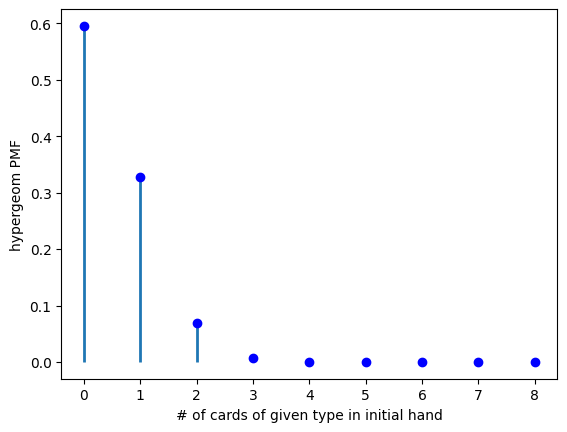

In [67]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, pmf_gt, 'bo')
ax.vlines(x, 0, pmf_gt, lw=2)
ax.set_xlabel('# of cards of given type in initial hand')
ax.set_ylabel('hypergeom PMF')
plt.show()

### Other card types

## Simulation

In [68]:
words_dict = {}

# Iterate through the word_dict and transform it into a better dictionary for choosing random words
for word, word_type in word_dict.items():
    if word_type not in words_dict:
        words_dict[word_type] = [word]
    else:
        words_dict[word_type].append(word)

In [69]:
def create_card_pool(total_cards=DEFAULT_WORD_COUNT, distribution=DEFAULT_DISTRIBUTION, masks=True):
    card_pool = []
    for card_type, n in distribution.items():
        # Calculate the number of cards for each type based on the percentage
        num_cards = n
        # Add cards of this type to the card pool
        if masks:
            card_pool.extend([card_type] * num_cards)
        else:
            twords = words_dict[card_type]
            sublist = [(random.choice(twords),card_type) for _ in range(num_cards)]
            card_pool.extend(sublist)
        
    return card_pool

def round_simulation(card_pool, n_rounds=1000, cards_in_hand=10):
    pass

In [70]:
pool = create_card_pool(masks=False)

In [71]:
pool

[('a policeman', 'SUBJECT - NOUN'),
 ('a cowboy', 'SUBJECT - NOUN'),
 ('a princess', 'SUBJECT - NOUN'),
 ('an indian', 'SUBJECT - NOUN'),
 ('an angel', 'SUBJECT - NOUN'),
 ('a scientist', 'SUBJECT - NOUN'),
 ('a princess', 'SUBJECT - NOUN'),
 ('a postman', 'SUBJECT - NOUN'),
 ('a dwarf', 'SUBJECT - NOUN'),
 ('an indian', 'SUBJECT - NOUN'),
 ('a teacher', 'SUBJECT - NOUN'),
 ('a knight', 'SUBJECT - NOUN'),
 ('a doctor', 'SUBJECT - NOUN'),
 ('a cook', 'SUBJECT - NOUN'),
 ('a cowboy', 'SUBJECT - NOUN'),
 ('a ghost', 'SUBJECT - NOUN'),
 ('a witch', 'SUBJECT - NOUN'),
 ('a devil', 'SUBJECT - NOUN'),
 ('a pilot', 'SUBJECT - NOUN'),
 ('a policeman', 'SUBJECT - NOUN'),
 ('a witch', 'SUBJECT - NOUN'),
 ('a knight', 'SUBJECT - NOUN'),
 ('a dwarf', 'SUBJECT - NOUN'),
 ('a doctor', 'SUBJECT - NOUN'),
 ('an angel', 'SUBJECT - NOUN'),
 ('however', 'LINKING WORDS'),
 ('also', 'LINKING WORDS'),
 ('however', 'LINKING WORDS'),
 ('finally', 'LINKING WORDS'),
 ('to draw', 'action VERBS'),
 ('to bath', 'ac

In [74]:
random.choices(pool,k=10)

[('an indian', 'SUBJECT - NOUN'),
 ('to draw', 'action VERBS'),
 ('a knight', 'SUBJECT - NOUN'),
 ('a doctor', 'SUBJECT - NOUN'),
 ('to be', 'sative VERBS'),
 ('a doctor', 'SUBJECT - NOUN'),
 ('angry', 'ADJECTIVE'),
 ('a dwarf', 'SUBJECT - NOUN'),
 ('to watch', 'action VERBS'),
 ('a guitar', 'OBJECT-NOUN')]